# Unlocked Challenge 4 Image Clasification

The Task:
The challenge is to build a machine learning model to classify images of "La Eterna". This can be done in a variety of ways. For this tutorial we will be focusing on building an image classification using artificial neural nets (ANN).

In [4]:
# importing libraries
import os
import glob
import shutil
import random

### Download and Prepare The Dataset
Dataset Link: https://github.com/Z-Unlocked/Unlocked_Challenge_4.git

Steps :
1. CLone the repo 
2. Create the directory for train and validation inside the datasets dir
3. Move the downloaded datasets to the newly created dir
4. Clean the unused folders 

In [8]:

# [STEP 1] Clone the repo
! git clone https://github.com/Z-Unlocked/Unlocked_Challenge_4.git

# clean datasets folder if already exists
if os.path.exists("datasets"):
  shutil.rmtree("datasets/")
  
# [STEP 2] Prepare datasets folder for train and validation
os.makedirs("datasets/train/la_eterna", exist_ok=True) 
os.makedirs("datasets/train/others", exist_ok=True) 
os.makedirs("datasets/val/la_eterna", exist_ok=True) 
os.makedirs("datasets/val/others", exist_ok=True) 

# [STEP 3] Move the downloaded datasets to train and validation in 80/20 ratio

dir = "Unlocked_Challenge_4/data_cleaned/" # cloned repo
train_dir = dir + "Train"  # train dir inside cloned repo
test_dir = dir + "scraped_images/image_files/"  # test dir inside cloned repo

# List of Train Images
la_eterna = glob.glob(train_dir+"/la_eterna/*") 
others = glob.glob(train_dir+"/other_flowers/*")

val_size = int(len(la_eterna)*0.2),int(len(others)*0.2)
random.shuffle(la_eterna) #shuffling 
random.shuffle(others)  #shuffling

def move_images_to_datasets(files,val_size,folder):
  """This function copies the files to the datasets folder.
     
  Args:
      files : List of all the images inside the given folder
      val_size : Validation size to split the train and val.
      folder : Folder inside train folder
  """
  # Copy images 
  destination = "datasets/train/" + folder + "/"
  for file in files[val_size:]:
    file_name = file.split("/")[-1]
    shutil.copy2(file, destination + file_name) 

  destination = "datasets/val/" + folder + "/"
  for file in files[:val_size]:
    file_name = file.split("/")[-1]
    shutil.copy2(file, destination + file_name) 


move_images_to_datasets(la_eterna,val_size[0],folder="la_eterna") # move la_eterna images
move_images_to_datasets(others,val_size[1],folder="others")  # move others images

print("Total Datasets: ",len(glob.glob("datasets/*/*/*")))
print("Total Train Datasets: ",len(glob.glob("datasets/train/*/*")))
print("Total Val Datasets: ",len(glob.glob("datasets/val/*/*")))

# [STEP 4] Clean the cloned folder
shutil.rmtree("Unlocked_Challenge_4")


Cloning into 'Unlocked_Challenge_4'...
remote: Enumerating objects: 660, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 660 (delta 6), reused 4 (delta 0), pack-reused 645
Receiving objects: 100% (660/660), 26.79 MiB | 28.55 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Total Datasets:  536
Total Train Datasets:  430
Total Val Datasets:  106


### Image Processing


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 430
     Root location: datasets/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 106
     Root location: datasets/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
len(os.listdir("datasets/train/la_eterna")),len(os.listdir("datasets/train/others"))

(127, 303)

In [ ]:
test_dir = "Unlocked_Challenge_4/data_cleaned/scraped_images/"
test_datasets = datasets.ImageFolder(test_dir,data_transforms["val"])
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=100,shuffle=True, num_workers=4)
test_dataset_sizes = len(test_datasets)
print(test_dataset_sizes)

100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


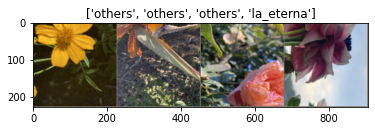

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3449 Acc: 0.8574
val Loss: 0.0563 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2720 Acc: 0.8946
val Loss: 0.0261 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.2314 Acc: 0.9091
val Loss: 0.0092 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2808 Acc: 0.8926
val Loss: 0.0052 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1727 Acc: 0.9525
val Loss: 0.0113 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1556 Acc: 0.9421
val Loss: 0.0179 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1817 Acc: 0.9339
val Loss: 0.0044 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0643 Acc: 0.9814
val Loss: 0.0028 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1147 Acc: 0.9690
val Loss: 0.0033 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1001 Acc: 0.9752
val Loss: 0.0045 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0616 Acc: 0.9793
val Loss: 0.0059 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1056 Acc: 0.9628
val Loss: 0.0041 Acc: 1.0000

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


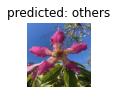

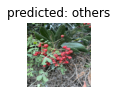

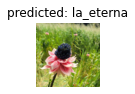

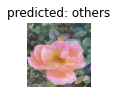

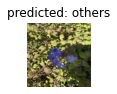

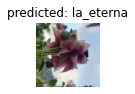

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

class ResNet18(nn.Module):
    """ResNet18 pretrained model definition."""
    def __init__(self,out_size:int):
        super(ResNet18,self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
                nn.Linear(in_features,out_size),
                nn.Sigmoid()
            )
    def forward(self,x):
        return self.model(x)
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
# model_conv = ResNet18(out_size=2)
# model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# define model

class DenseNet121(nn.Module):
    """DenseNet121 pretrained model definition."""
    def __init__(self,out_size:int):
        super(DenseNet121,self).__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
                nn.Linear(in_features,in_features*2),
                nn.Dropout(0.5),
                nn.Linear(in_features*2,in_features),
                nn.Dropout(0.25),
                nn.Linear(in_features,out_size),
                nn.Sigmoid()
            )
    def forward(self,x):
        return self.model(x)

d_model = DenseNet121(out_size=2)
d_model = d_model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
d_optimizer_conv = optim.SGD(d_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
d_exp_lr_scheduler = lr_scheduler.StepLR(d_optimizer_conv, step_size=7, gamma=0.1)

d_model_conv = train_model(d_model, criterion, d_optimizer_conv,
                         d_exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6171 Acc: 0.6983
val Loss: 0.5960 Acc: 0.7115

Epoch 1/24
----------
train Loss: 0.5933 Acc: 0.7045
val Loss: 0.5692 Acc: 0.7115

Epoch 2/24
----------
train Loss: 0.5715 Acc: 0.7128
val Loss: 0.5268 Acc: 0.8462

Epoch 3/24
----------
train Loss: 0.5391 Acc: 0.7851
val Loss: 0.4767 Acc: 0.9038

Epoch 4/24
----------
train Loss: 0.4925 Acc: 0.8574
val Loss: 0.4266 Acc: 0.9231

Epoch 5/24
----------
train Loss: 0.4819 Acc: 0.8616
val Loss: 0.4061 Acc: 0.9038

Epoch 6/24
----------
train Loss: 0.4682 Acc: 0.8781
val Loss: 0.3788 Acc: 0.9615

Epoch 7/24
----------
train Loss: 0.4557 Acc: 0.8822
val Loss: 0.3824 Acc: 0.9615

Epoch 8/24
----------
train Loss: 0.4393 Acc: 0.9029
val Loss: 0.3749 Acc: 0.9808

Epoch 9/24
----------
train Loss: 0.4349 Acc: 0.9174
val Loss: 0.3654 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.4357 Acc: 0.9050
val Loss: 0.3710 Acc: 0.9808

Epoch 11/24
----------
train Loss: 0.4314 Acc: 0.9132
val Loss: 0.3760 Acc: 1.0000

Epoch 12/24
----------
t

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.1869 Acc: 0.9256
val Loss: 0.0399 Acc: 0.9906

Epoch 1/24
----------
train Loss: 0.2347 Acc: 0.9000
val Loss: 0.0381 Acc: 0.9906

Epoch 2/24
----------
train Loss: 0.1980 Acc: 0.9233
val Loss: 0.0505 Acc: 0.9811

Epoch 3/24
----------
train Loss: 0.2217 Acc: 0.9163
val Loss: 0.0315 Acc: 0.9906

Epoch 4/24
----------
train Loss: 0.2264 Acc: 0.9070
val Loss: 0.0463 Acc: 0.9811

Epoch 5/24
----------
train Loss: 0.1629 Acc: 0.9302
val Loss: 0.0429 Acc: 0.9906

Epoch 6/24
----------
train Loss: 0.1679 Acc: 0.9419
val Loss: 0.0378 Acc: 0.9906

Epoch 7/24
----------
train Loss: 0.2207 Acc: 0.9140
val Loss: 0.0659 Acc: 0.9811

Epoch 8/24
----------
train Loss: 0.1912 Acc: 0.9116
val Loss: 0.0442 Acc: 0.9906

Epoch 9/24
----------
train Loss: 0.1738 Acc: 0.9302
val Loss: 0.0627 Acc: 0.9717

Epoch 10/24
----------
train Loss: 0.2182 Acc: 0.9209
val Loss: 0.0429 Acc: 0.9811

Epoch 11/24
----------
train Loss: 0.1900 Acc: 0.9209
val Loss: 0.0553 Acc: 0.9717

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


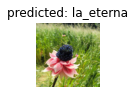

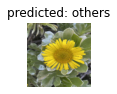

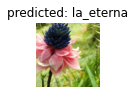

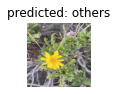

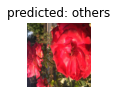

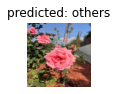

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


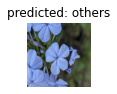

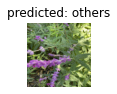

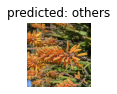

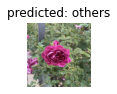

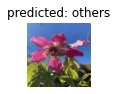

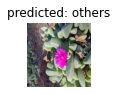

In [ ]:
def visualize__test_images(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize__test_images(model_conv)

plt.ioff()
plt.show()

In [ ]:
outs = []
model_conv.eval()
with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            outs+=outputs.detach().cpu()

outs

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor([-1.9061,  2.3480]),
 tensor([-3.7202,  2.9535]),
 tensor([-1.8930,  3.9739]),
 tensor([-3.9565,  4.0334]),
 tensor([-4.1398,  4.2137]),
 tensor([-3.3513,  4.6653]),
 tensor([-4.7973,  5.5009]),
 tensor([ 0.6804, -0.1370]),
 tensor([-1.9411,  2.5969]),
 tensor([-1.5070,  2.3018]),
 tensor([-3.0156,  4.7365]),
 tensor([-2.4014,  2.6516]),
 tensor([-3.9753,  5.8342]),
 tensor([-6.4807,  7.1451]),
 tensor([-3.0493,  3.0026]),
 tensor([-3.9470,  3.0057]),
 tensor([-0.4258,  1.1891]),
 tensor([-1.0246,  1.6030]),
 tensor([-0.2541,  1.4297]),
 tensor([-4.6841,  6.0522]),
 tensor([-3.8567,  3.6985]),
 tensor([-2.8560,  5.2598]),
 tensor([-4.3363,  5.9406]),
 tensor([-4.6313,  5.3044]),
 tensor([-5.0364,  6.6813]),
 tensor([-2.1515,  2.9961]),
 tensor([-0.1803,  1.3454]),
 tensor([-3.6000,  4.2666]),
 tensor([ 3.7713, -2.9563]),
 tensor([-1.4446,  2.4936]),
 tensor([-2.3331,  2.5229]),
 tensor([-3.2987,  1.9320]),
 tensor([-2.9290,  3.4236]),
 tensor([-2.5578,  4.9018]),
 tensor([-4.63

In [ ]:
m = nn.Sigmoid()
output = m(outs[0])
output.numpy().tolist()

[0.12942084670066833, 0.912776529788971]

In [ ]:
outs[0].numpy()

array([ 0.6804126 , -0.13702185], dtype=float32)

In [ ]:
train_d = torch.utils.data.DataLoader(image_datasets["train"],batch_size=430)
val_d = torch.utils.data.DataLoader(image_datasets["val"],batch_size=106)


In [ ]:
model_conv.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_d):
        inputs = inputs.to(device)
        labels_t = labels.to(device)
        outputs_t = model_conv(inputs)

model_conv.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_d):
        inputs = inputs.to(device)
        labels_v = labels.to(device)
        outputs_v = model_conv(inputs)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss
def gen_metrics(preds,labels):
  _, preds = torch.max(preds, 1)
  labels  = labels.detach().cpu().numpy()
  preds   = preds.detach().cpu().numpy()
  target_names = ['la_eterna', 'others']
  print(classification_report(labels,preds, target_names=target_names))

  #Generate the confusion matrix
  cf_matrix = confusion_matrix(labels,preds)
  print("cf_matrix")
  print(cf_matrix)

  print("lg_loss")
  lg_loss = log_loss(labels,preds)
  print(lg_loss)

In [ ]:
#Generate metrics for train data
gen_metrics(outputs_t,labels_t)


              precision    recall  f1-score   support

   la_eterna       0.96      0.98      0.97       127
      others       0.99      0.98      0.99       303

    accuracy                           0.98       430
   macro avg       0.98      0.98      0.98       430
weighted avg       0.98      0.98      0.98       430

cf_matrix
[[124   3]
 [  5 298]]
lg_loss
0.642587465003666


In [ ]:
#Generate metrics for val data
gen_metrics(outputs_v,labels_v)


              precision    recall  f1-score   support

   la_eterna       1.00      0.97      0.98        31
      others       0.99      1.00      0.99        75

    accuracy                           0.99       106
   macro avg       0.99      0.98      0.99       106
weighted avg       0.99      0.99      0.99       106

cf_matrix
[[30  1]
 [ 0 75]]
lg_loss
0.3258450565315186


In [ ]:
model_conv.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels_test = labels.to(device)
        outputs_test = model_conv(inputs)

labels_t  = labels_test.detach().cpu().numpy()
preds_t   = outputs_test.detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def map_img(img):
  return img[0].split("/")[-1]

imgs = [img for img in map(map_img,test_datasets.imgs)]

In [ ]:
m = nn.Sigmoid()
input=outputs_test.detach().cpu()
output = m(input).numpy()
output[:5]

array([[0.1265401 , 0.93505883],
       [0.0259564 , 0.97358656],
       [0.02846741, 0.9908517 ],
       [0.022101  , 0.97469383],
       [0.07527599, 0.97703344]], dtype=float32)

In [ ]:
import pandas as pd

submission_df = pd.DataFrame(output, columns =['la_eterna','other_flower'])
submission_df['images'] = imgs
submission_df = submission_df.reindex(columns=['images','la_eterna','other_flower'])
submission_df.head()

,images,la_eterna,other_flower
0,img_00.jpg,0.126540,0.935059
1,img_01.jpg,0.025956,0.973587
2,img_02.jpg,0.028467,0.990852
3,img_03.jpg,0.022101,0.974694
4,img_04.jpg,0.075276,0.977033


In [ ]:
submission_df.to_csv('submission_file.csv', index = False)